# Account study (novax)

## Import

In [1]:
import pandas as pd
import json
from collections import Counter

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

import account_util as ut

## Dataset preparation

In [2]:
df = pd.read_csv('../tweets_novax.csv',low_memory=False,
                 usecols=['user_id','user_created_at','user_screen_name','user_mentions','created_at','user_verified',
                         'user_url_cred'])

In [3]:
df['user_created_at'] = pd.to_datetime(df['user_created_at'], format="%a %b %d %X %z %Y")
df['created_at'] = pd.to_datetime(df['created_at'], format="%a %b %d %X %z %Y")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328997 entries, 0 to 1328996
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype              
---  ------            --------------    -----              
 0   created_at        1328997 non-null  datetime64[ns, UTC]
 1   user_id           1328997 non-null  int64              
 2   user_screen_name  1328997 non-null  object             
 3   user_verified     1328997 non-null  bool               
 4   user_created_at   1328997 non-null  datetime64[ns, UTC]
 5   user_mentions     1328997 non-null  object             
 6   user_url_cred     851951 non-null   float64            
dtypes: bool(1), datetime64[ns, UTC](2), float64(1), int64(1), object(2)
memory usage: 62.1+ MB


In [5]:
dfAccount = pd.DataFrame()

df1 = df.groupby(['user_screen_name']).sum()
df1.loc[:,df1.columns[df1.columns.str.contains('id', regex=False)==False]]

dfAccount['user_verified'] = df1['user_verified']>0 
dfAccount['created_at'] = df.groupby('user_screen_name').first()['user_created_at']

### General info study

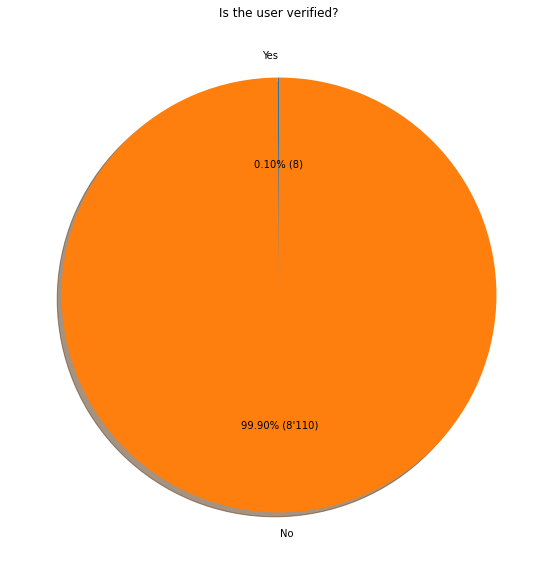

"Total users: 8'118"

In [6]:
#How many users verify the account (absolute)
values = [sum(dfAccount['user_verified']), len(dfAccount) - sum(dfAccount['user_verified'])]
names = ['Yes', 'No']

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(values, labels=names, autopct=lambda p:f'{p:.2f}% ({p*sum(values)/100 :,.0f})'.replace(',', '\''),
        shadow=True, startangle=90)

plt.title("Is the user verified?")
plt.show()
"Total users: {:,}".format(len(dfAccount)).replace(',', '\'')

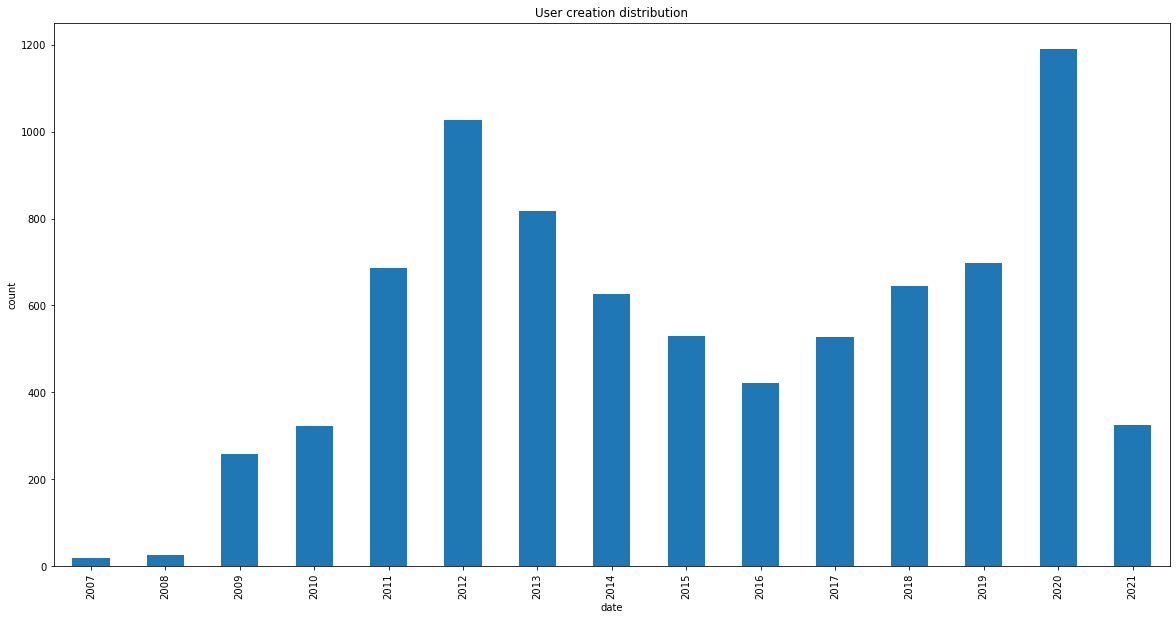

In [7]:
plt.figure(figsize=(20,10))
dfAccount.groupby([dfAccount["created_at"].dt.year])['created_at'].count().plot(kind="bar")
plt.xlabel('date')
plt.ylabel('count')
plt.title('User creation distribution')
plt.show()

From the graph above, we can see two important peaks in 2012 and 2020 and a significant growth in the number of profiles created in 2009.
The first growth, which dates back to 2009, is due to the introduction (along with French, German and Spanish) of Italian as an active language. 

Then, in 2012, twitter for the first time beat a news of institutional importance well in advance of the traditional media: the death of President Emeritus Oscar Luigi Scalfaro. This led to an increase, especially in Italy, of Twitter subscriptions.

Finally, towards the end of March 2020, especially in Italy, there was a strict lockdown due to Covid. This lockdown, that forced everyone at home, has led to an increase in subscriptions to social networks, including Twitter, to fill the moments of boredom.

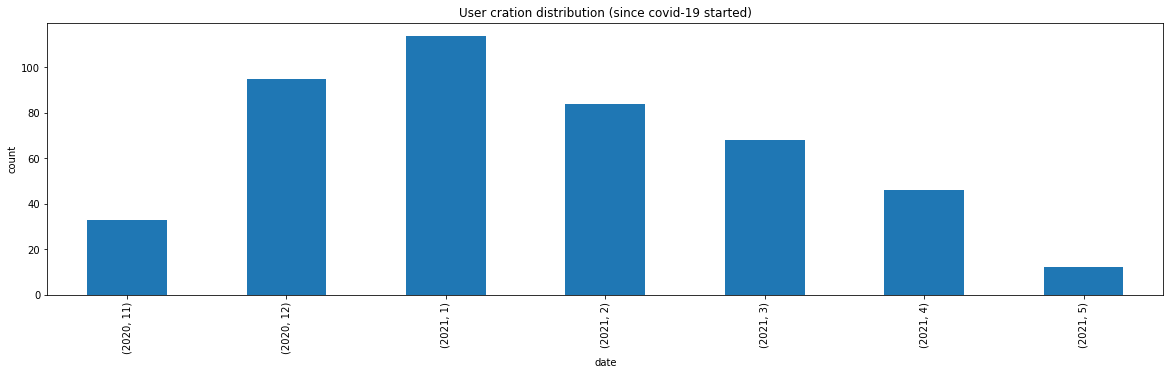

In [8]:
#When the most user are created (since covid-19 started) 
date = "2020-11-17" # --> The first case of infection ascertained by COVID-19 is recorded

df1 = dfAccount[(dfAccount['created_at']> date)] 

plt.figure(figsize=(20,5))
df1.groupby([df1["created_at"].dt.year,df1["created_at"].dt.month])['created_at'].count().plot(kind="bar")
plt.xlabel('date')
plt.ylabel('count')
plt.title('User cration distribution (since covid-19 started)')
plt.show()

### General study (tweet, retweet, replies)

#### Definition lists of intresting users

In [9]:
with open('../1_Dataset_preparation/listControlledUsers.json','r') as file_object:  
    data = json.load(file_object)  

listNovax = data['Novax']
listLinkLow = data['link_low']
listProvax = data['Provax']


### All type of posts

In [10]:
#Perparation i df grouped by name
dfTweetByName = pd.DataFrame(df.loc[:,'user_screen_name'])
dfTweetByName = ut.get_df_raggruped(dfTweetByName,'tweet_count','user_screen_name')
dfTweetByName = ut.add_user_type(dfTweetByName,listNovax,listProvax,listLinkLow)
dfTweetByName

,tweet_count,user_type
user_screen_name,,
Piero42395724,4803,Novax
IacobellisT,4333,Novax
Pietro_Otto,4123,Novax
TommyBrain,4115,Novax
Z3r0Rules,4081,Novax
...,...,...
antoniopaddeu,10,Not defined
MinaAlessio,10,Not defined
AleMacchiavelli,10,Not defined


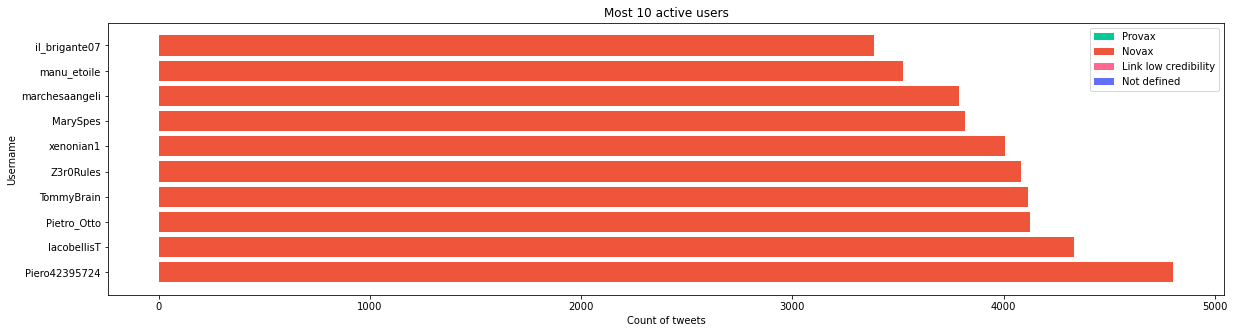

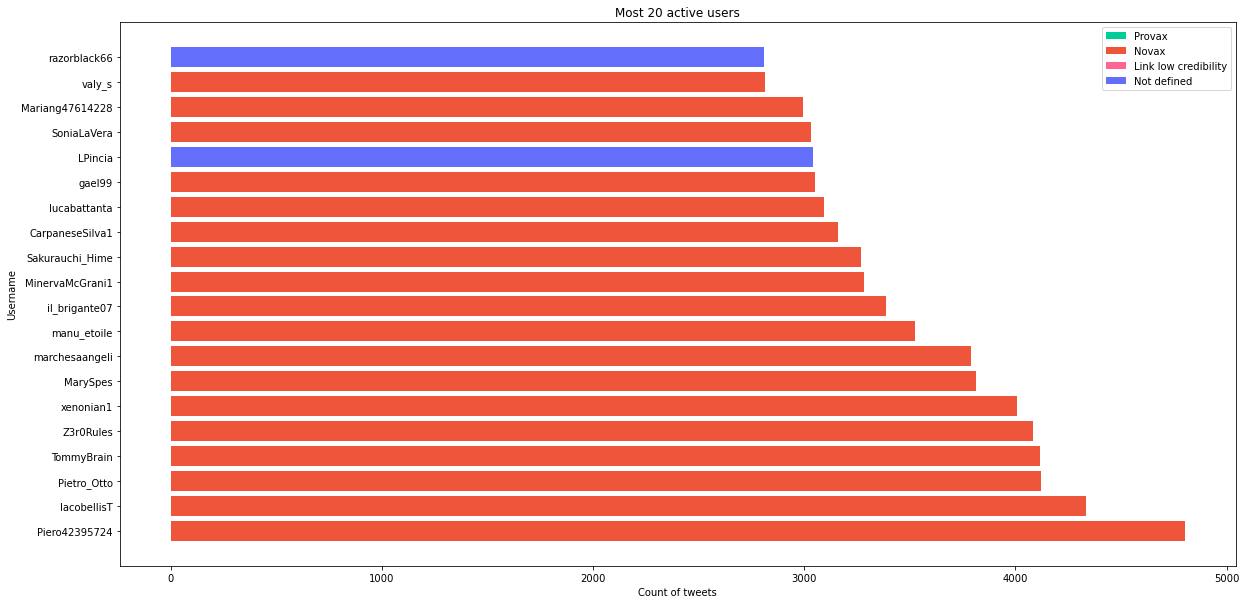

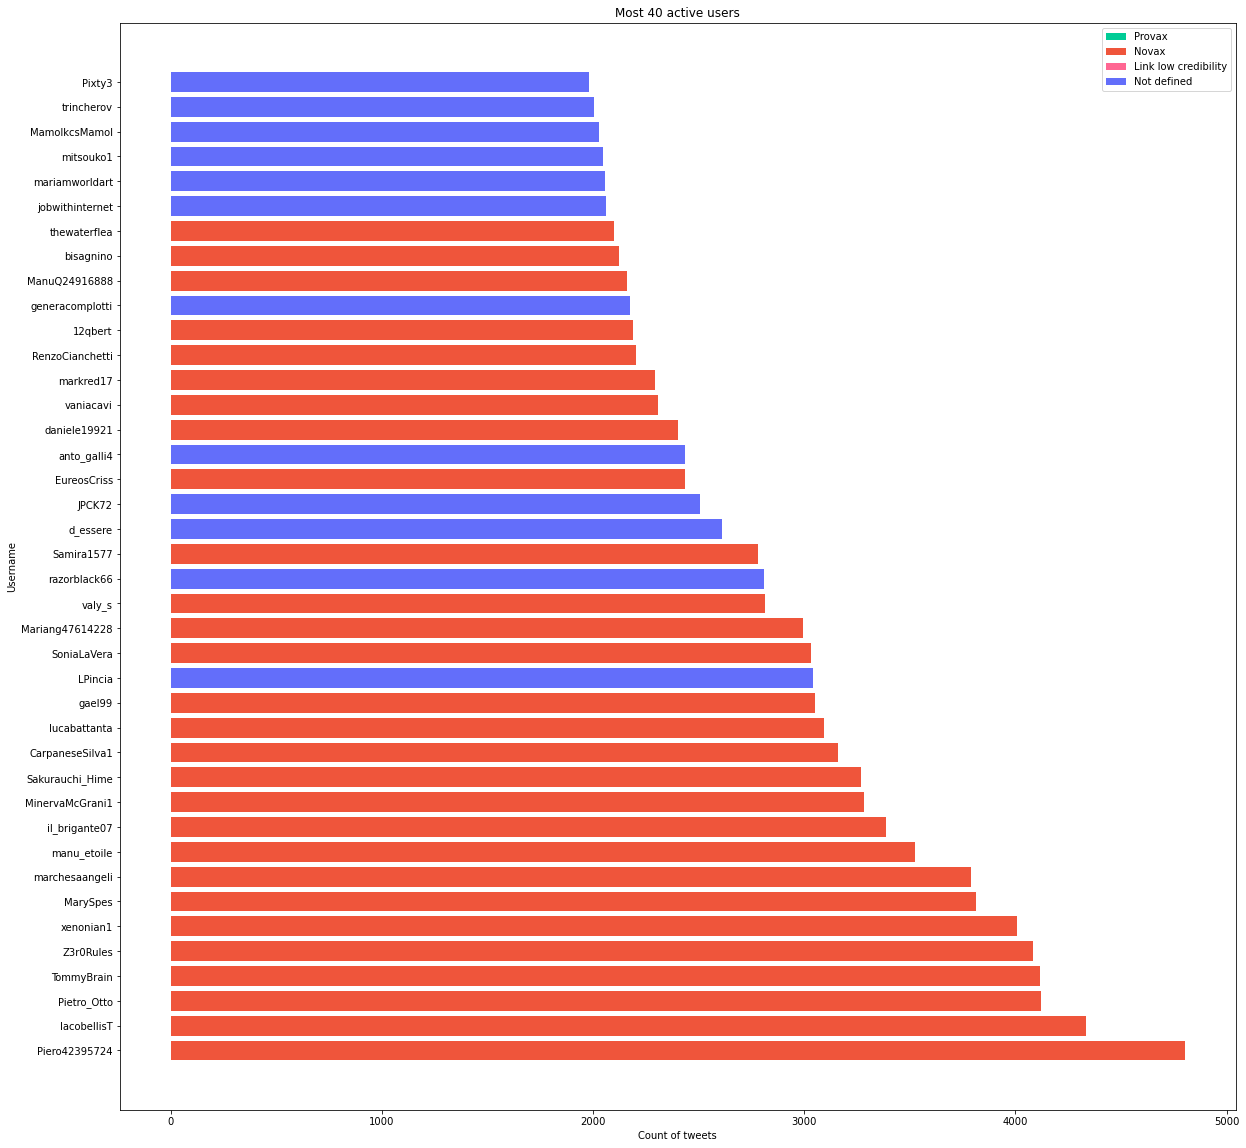

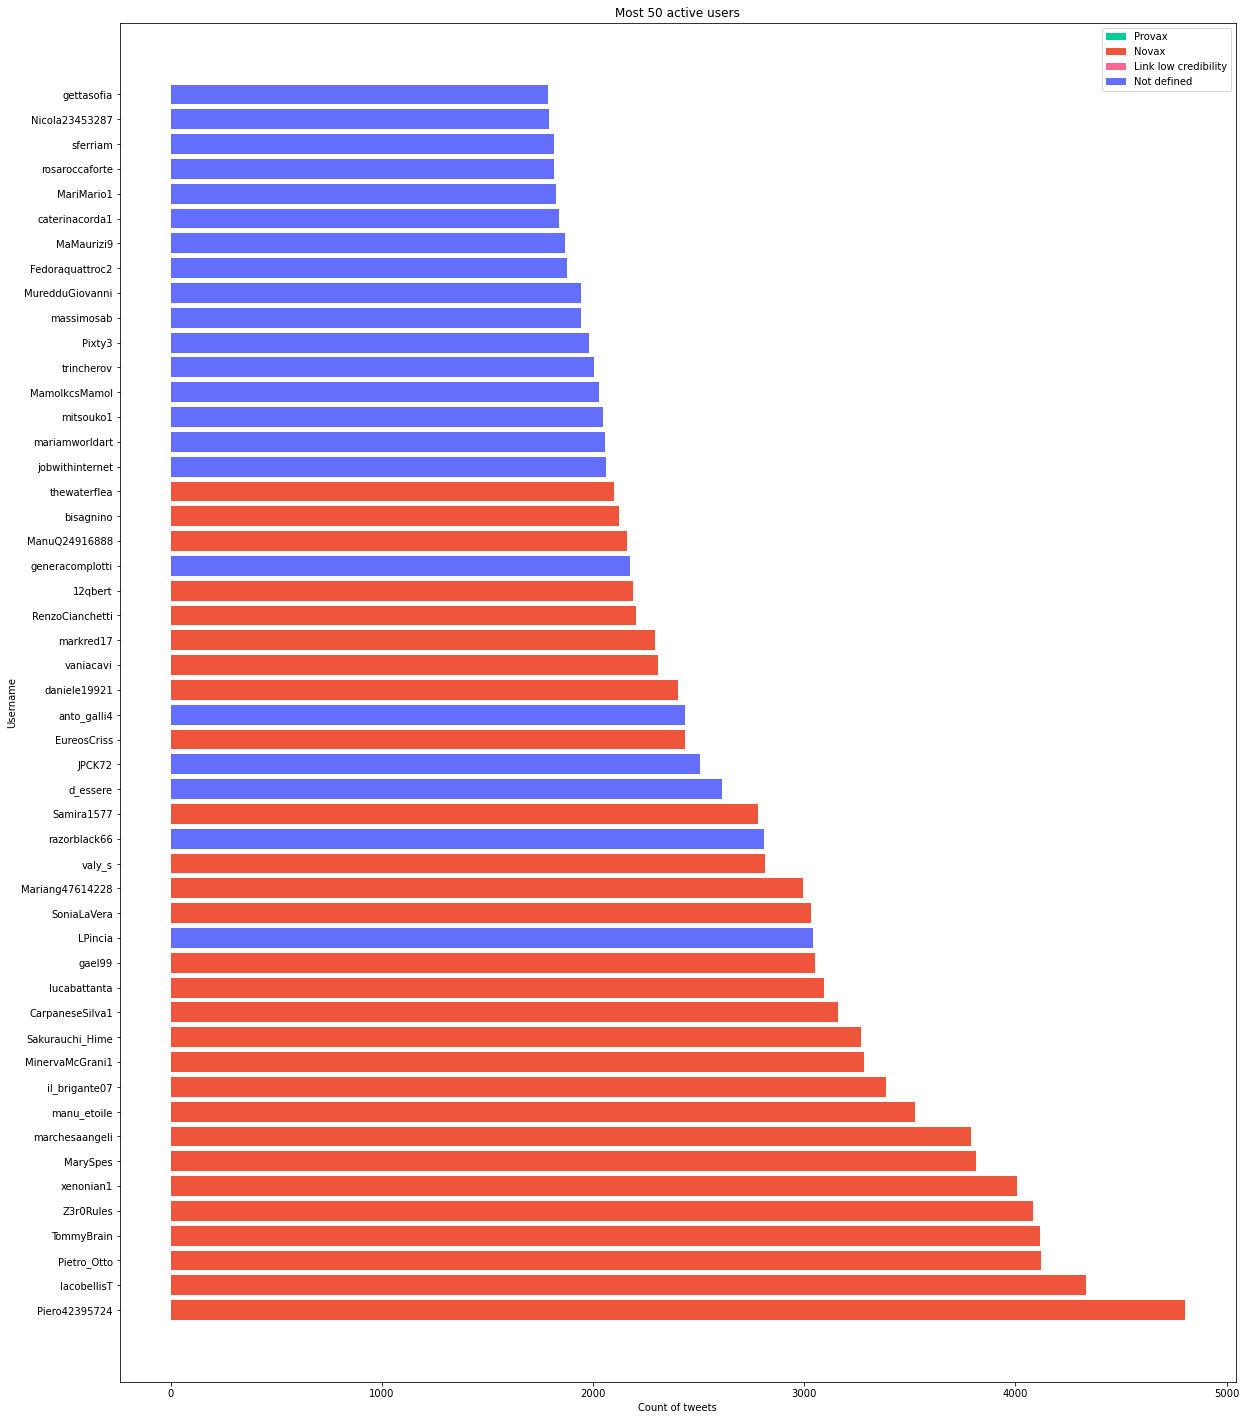

In [11]:
#Show the most active user (in general)
for i in (10,20,40,50):
    ut.print_histogram_users(dfTweetByName,i,'tweet_count','Most %d active users'%i,'Count of tweets')

### Tweet study

In [12]:
# get top 20 most frequent Tweet account
df_tweets = pd.read_csv('../Tweet_split_type/tweets.csv')
df_tweets = df_tweets[[ele in df.user_id for ele in df_tweets.user_id]]
df_tweets = ut.get_df_raggruped(df_tweets,'tweet_count','user_screen_name')
df_tweets = ut.add_user_type(df_tweets,listNovax,listProvax,listLinkLow)
df_tweets

,tweet_count,user_type
user_screen_name,,
GenCar5,117.0,Not defined
davide_tommasin,78.0,Not defined
doomboy,71.0,Not defined
mante,66.0,Not defined
sasakifujika,38.0,Not defined
...,...,...
marcocapo79,1.0,Not defined
bimbomobile,1.0,Not defined
gecco,1.0,Not defined


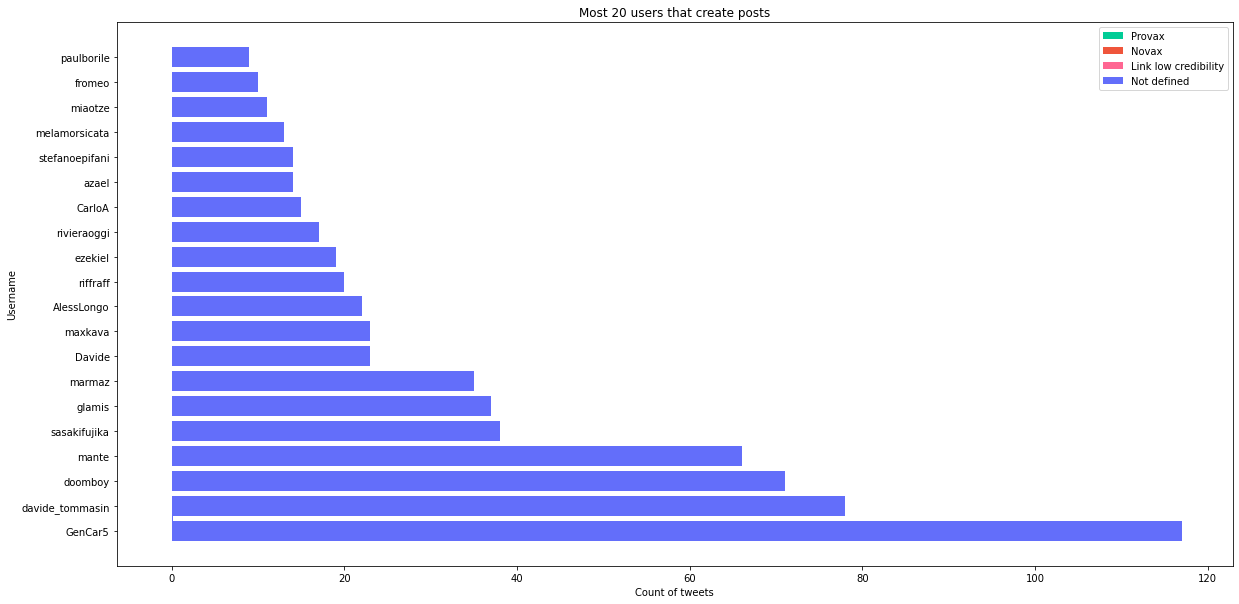

In [13]:
ut.print_histogram_users(df_tweets,20,'tweet_count','Most %d users that create posts'%20,'Count of tweets')

### Retweet study

In [14]:
retweet = pd.read_csv('../Tweet_split_type/retweet.csv',low_memory=False)
retweet = retweet[[ele in df.user_id for ele in retweet.user_id]]

df_retweet = pd.DataFrame()
df_retweet['all_rt']  = retweet.groupby('rt_user_screen_name').count()['user_id']
df_retweet['self_rt'] = retweet.groupby('rt_user_screen_name').sum()['is_self_rt']
df_retweet['real_rt'] = df_retweet['all_rt'] - df_retweet['self_rt']
df_retweet.sort_values('real_rt',ascending=False,inplace=True)

df_retweet = ut.add_user_type(df_retweet,listNovax,listProvax,listLinkLow)
df_retweet

,all_rt,self_rt,real_rt,user_type
rt_user_screen_name,,,,
RobertoBurioni,34,0,34,Provax
GiacomoGorini,20,0,20,Not defined
MinervaMcGrani1,15,0,15,Novax
noitre32,13,0,13,Novax
davcarretta,13,0,13,Not defined
...,...,...,...,...
Phastidio,1,0,1,Not defined
Pgreco_,1,0,1,Not defined
PersilQ,1,0,1,Not defined


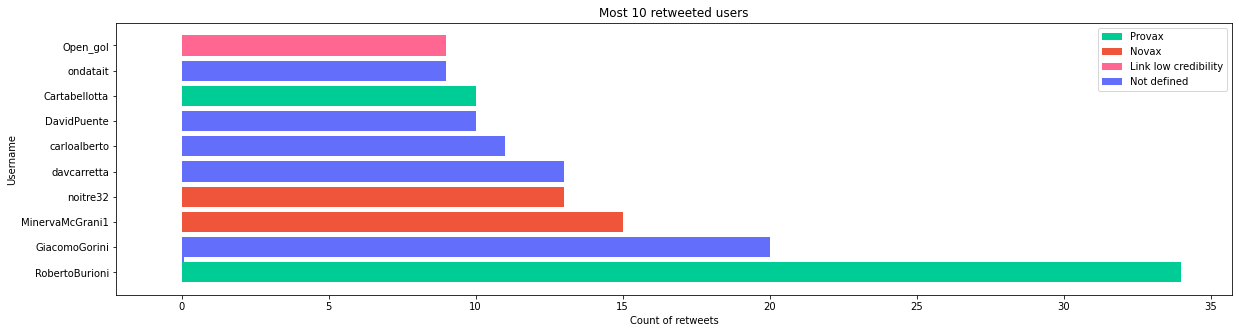

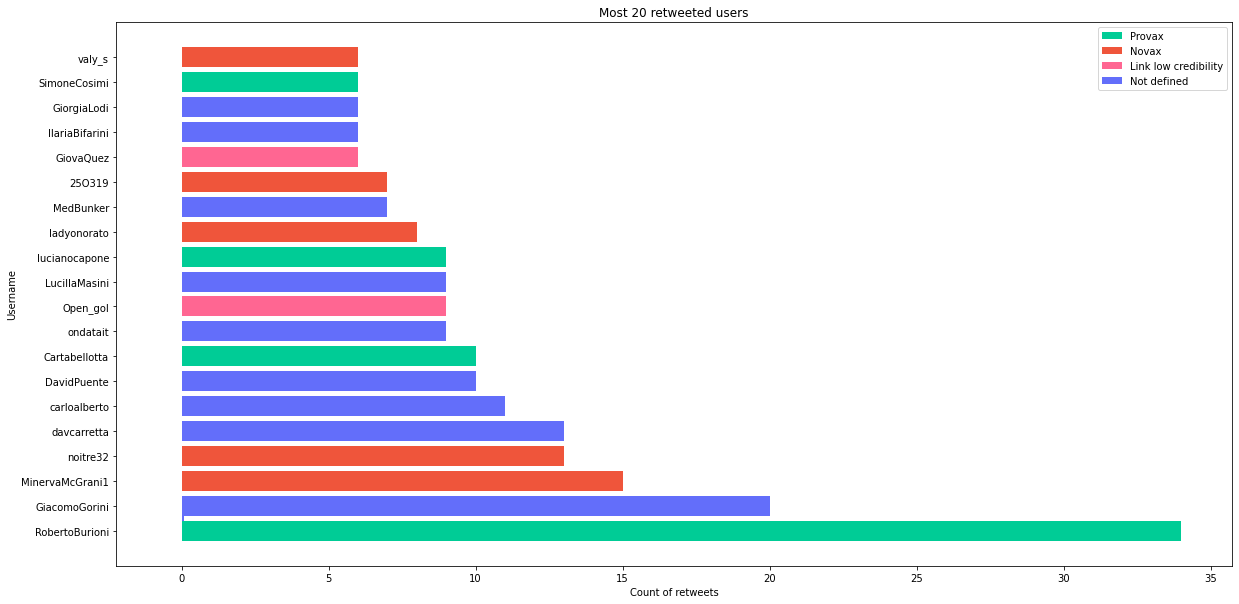

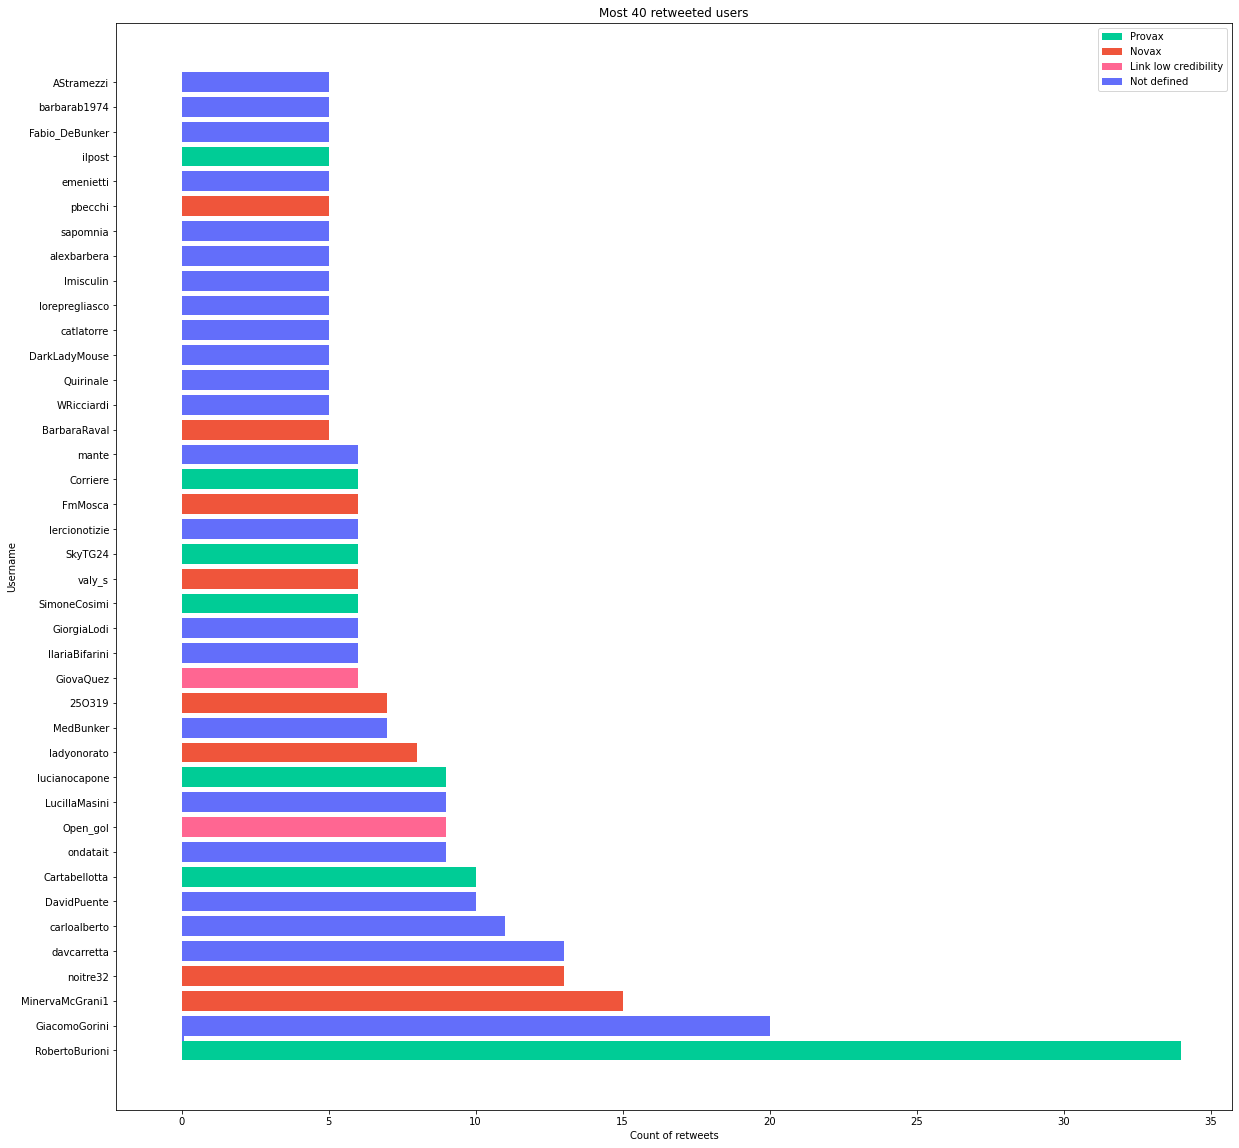

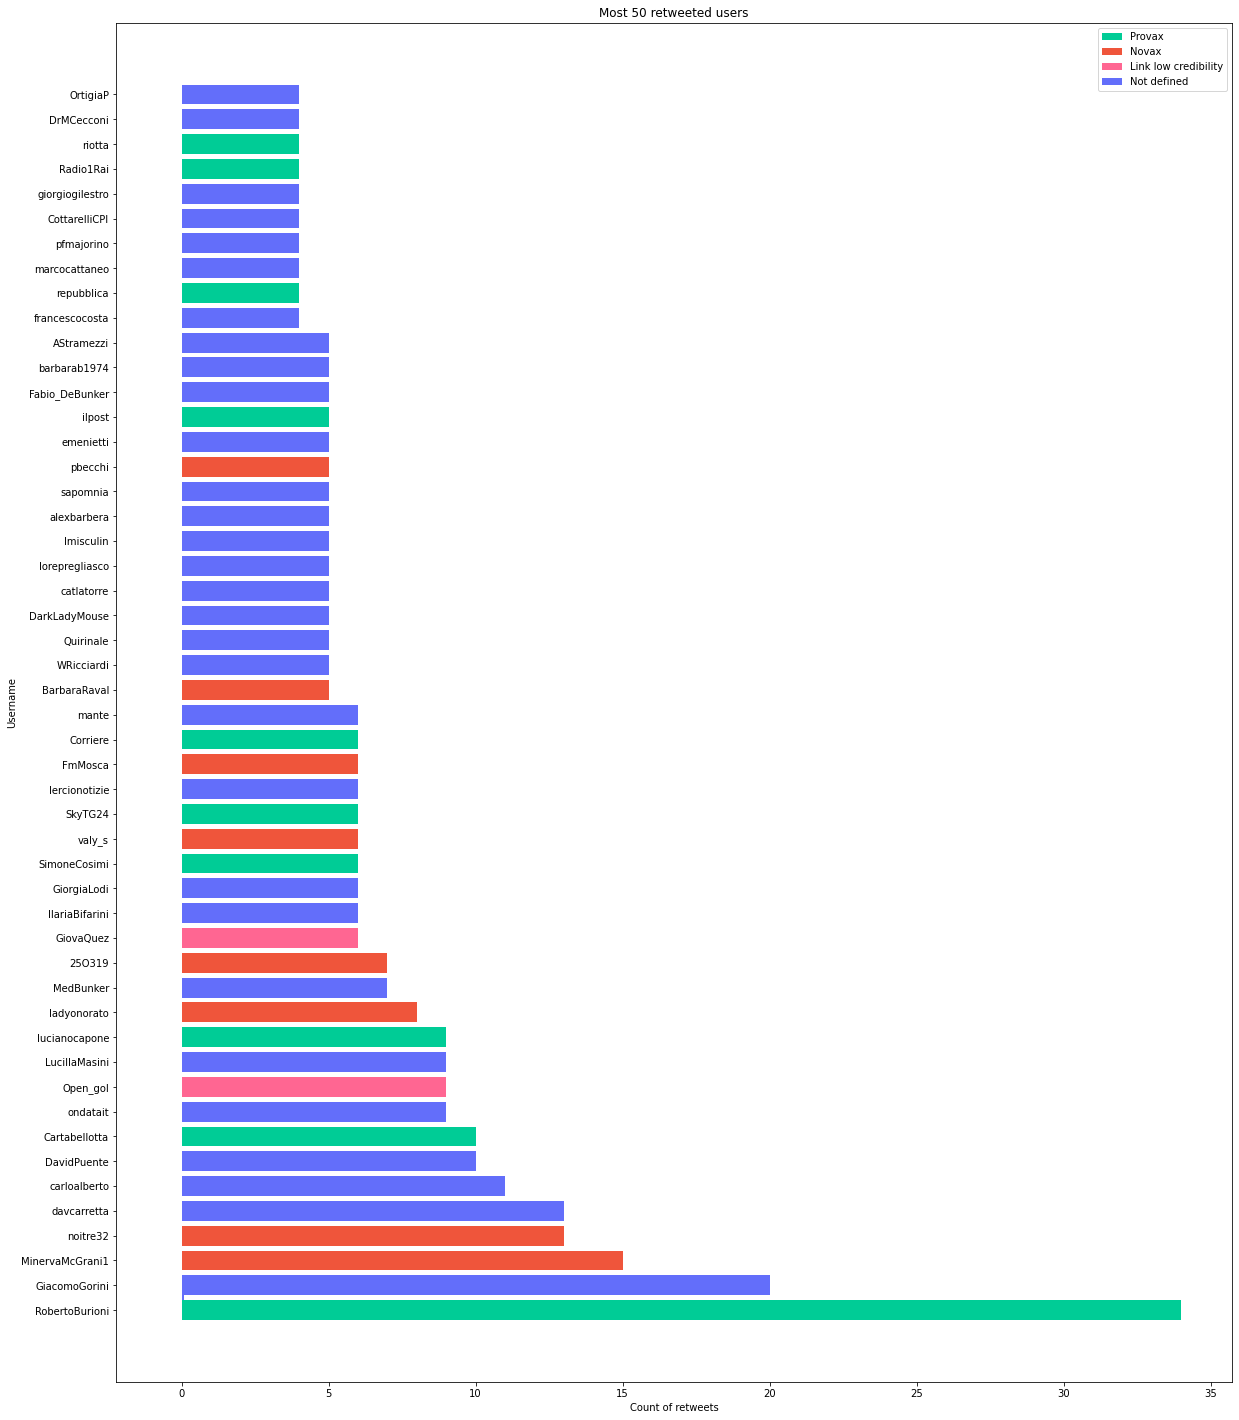

In [15]:
for i in (10,20,40,50):
        ut.print_histogram_users(df_retweet,i,'real_rt','Most %d retweeted users'%i,'Count of retweets')

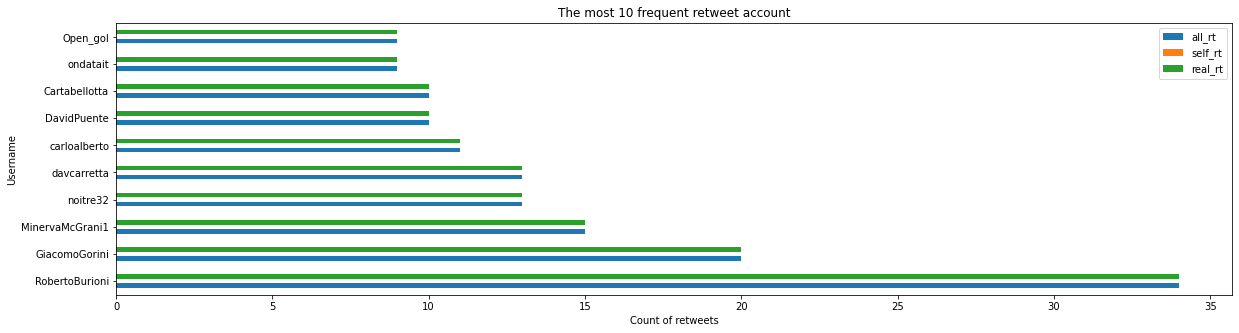

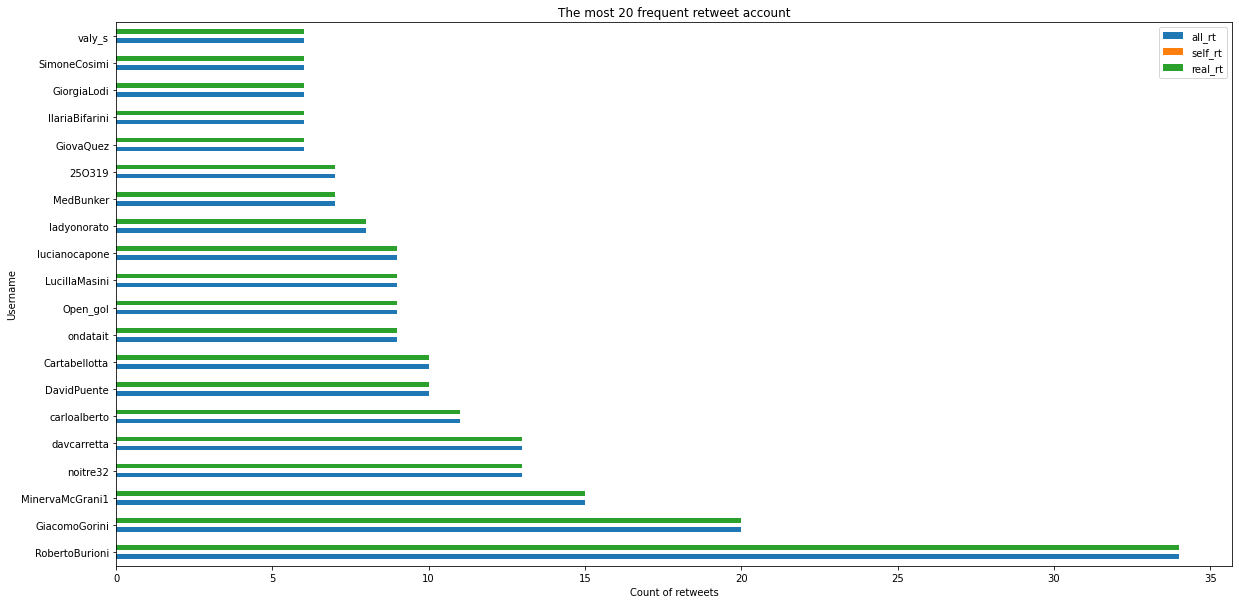

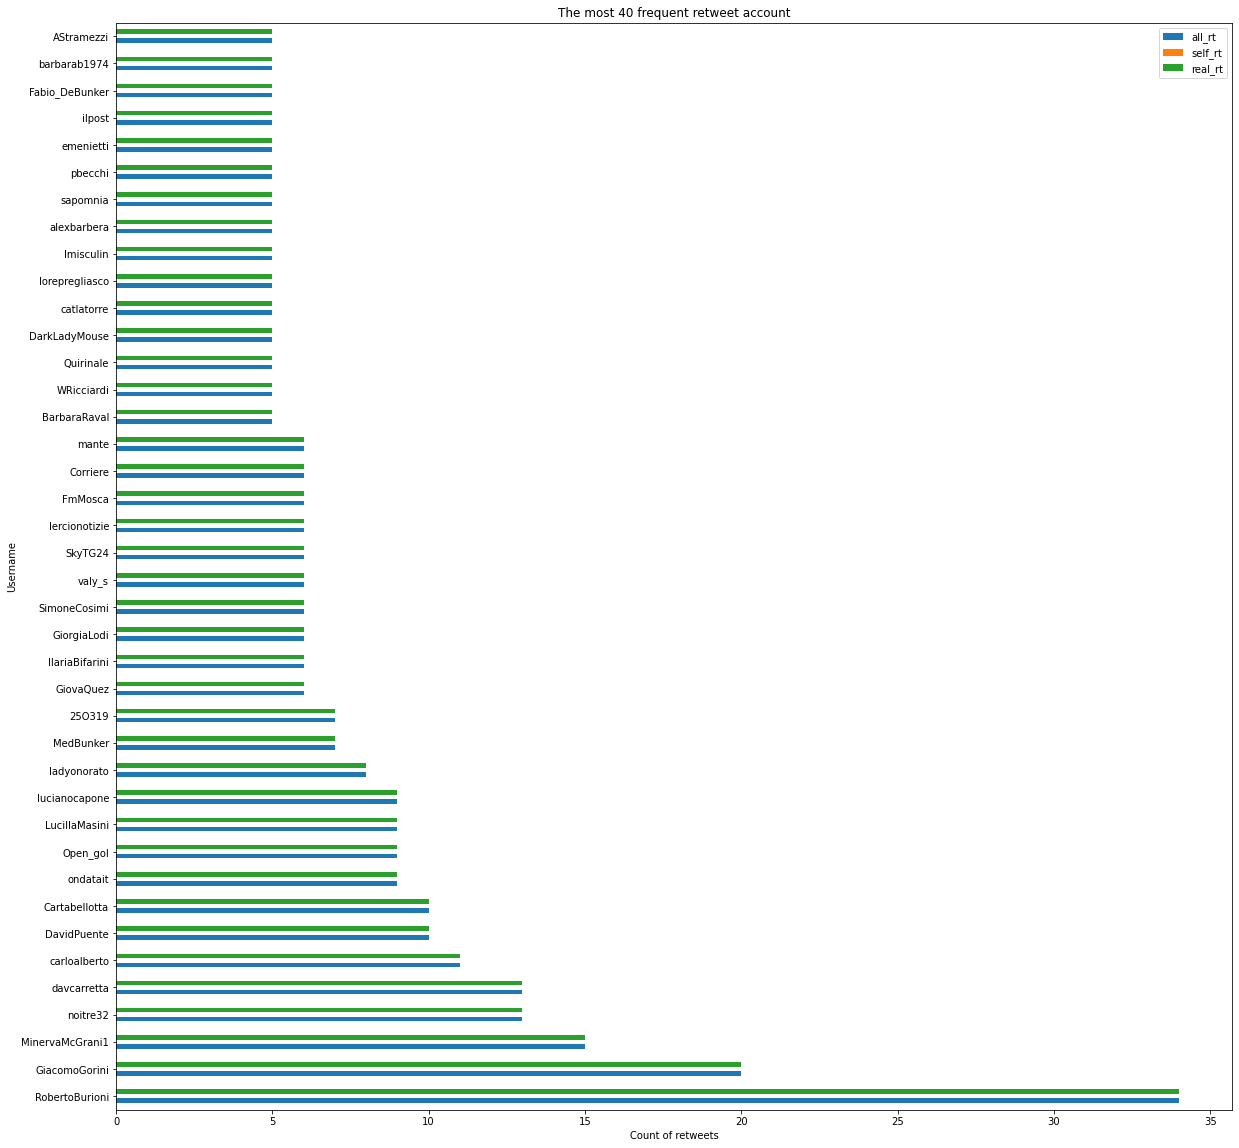

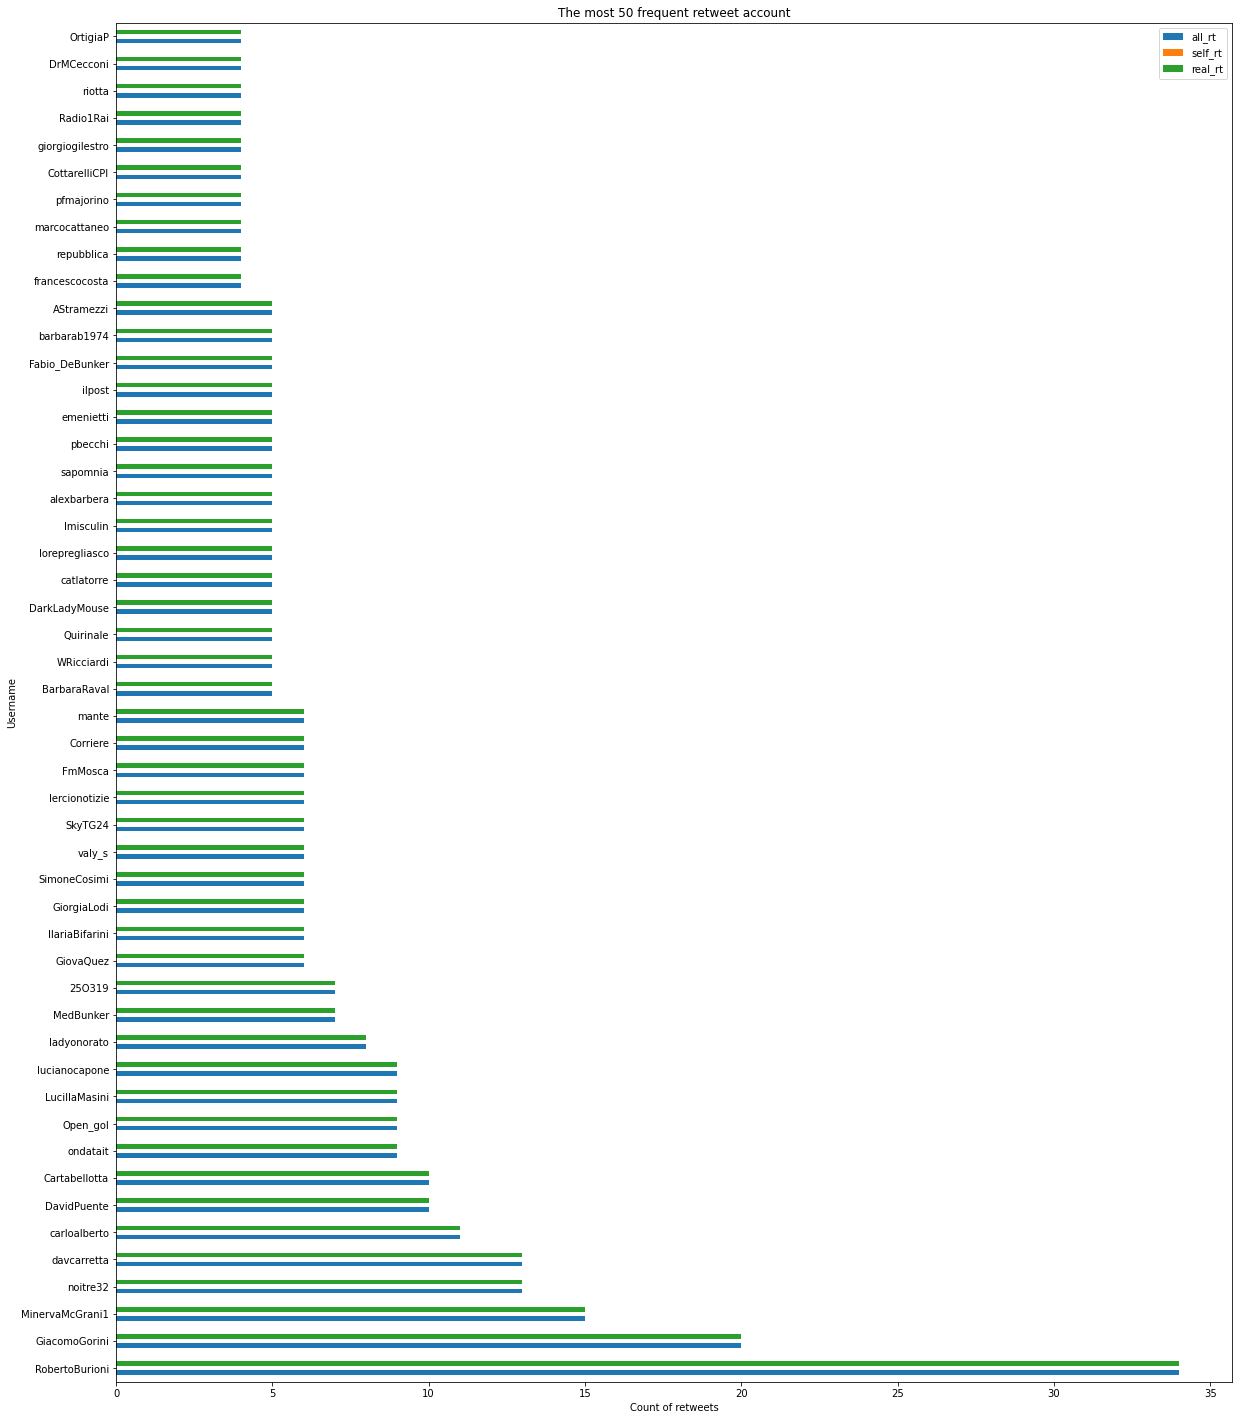

In [16]:
for i in (10,20,40,50):
    df_retweet.head(i).plot(kind='barh',figsize=(20,i/2))
    plt.title("The most %d frequent retweet account"%i)
    plt.xlabel("Count of retweets")
    plt.ylabel("Username")
    plt.show()

### Reply study

In [17]:
reply = pd.read_csv('../Tweet_split_type/reply.csv',low_memory=False)
reply = reply[[ele in df.user_id for ele in reply.user_id]]

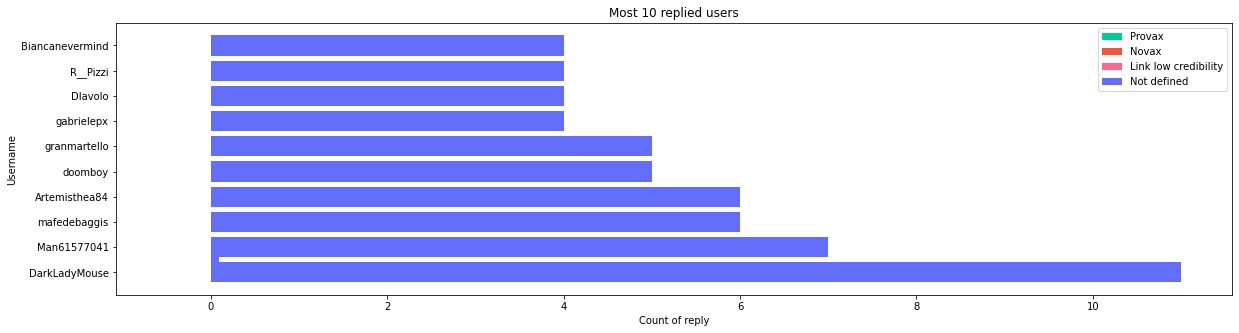

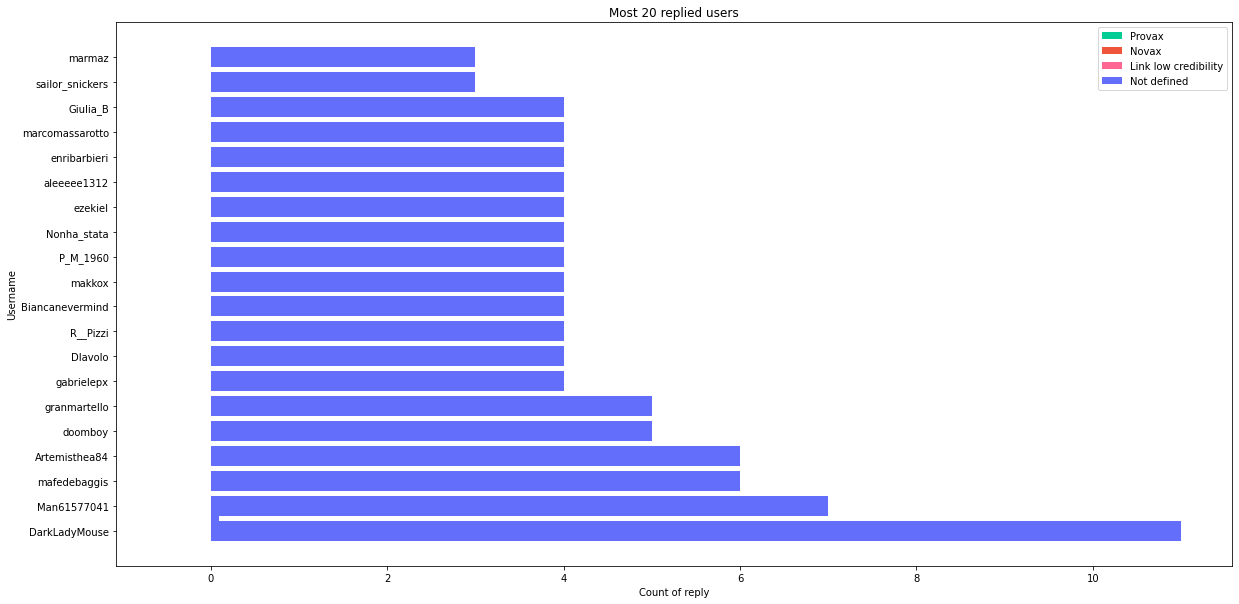

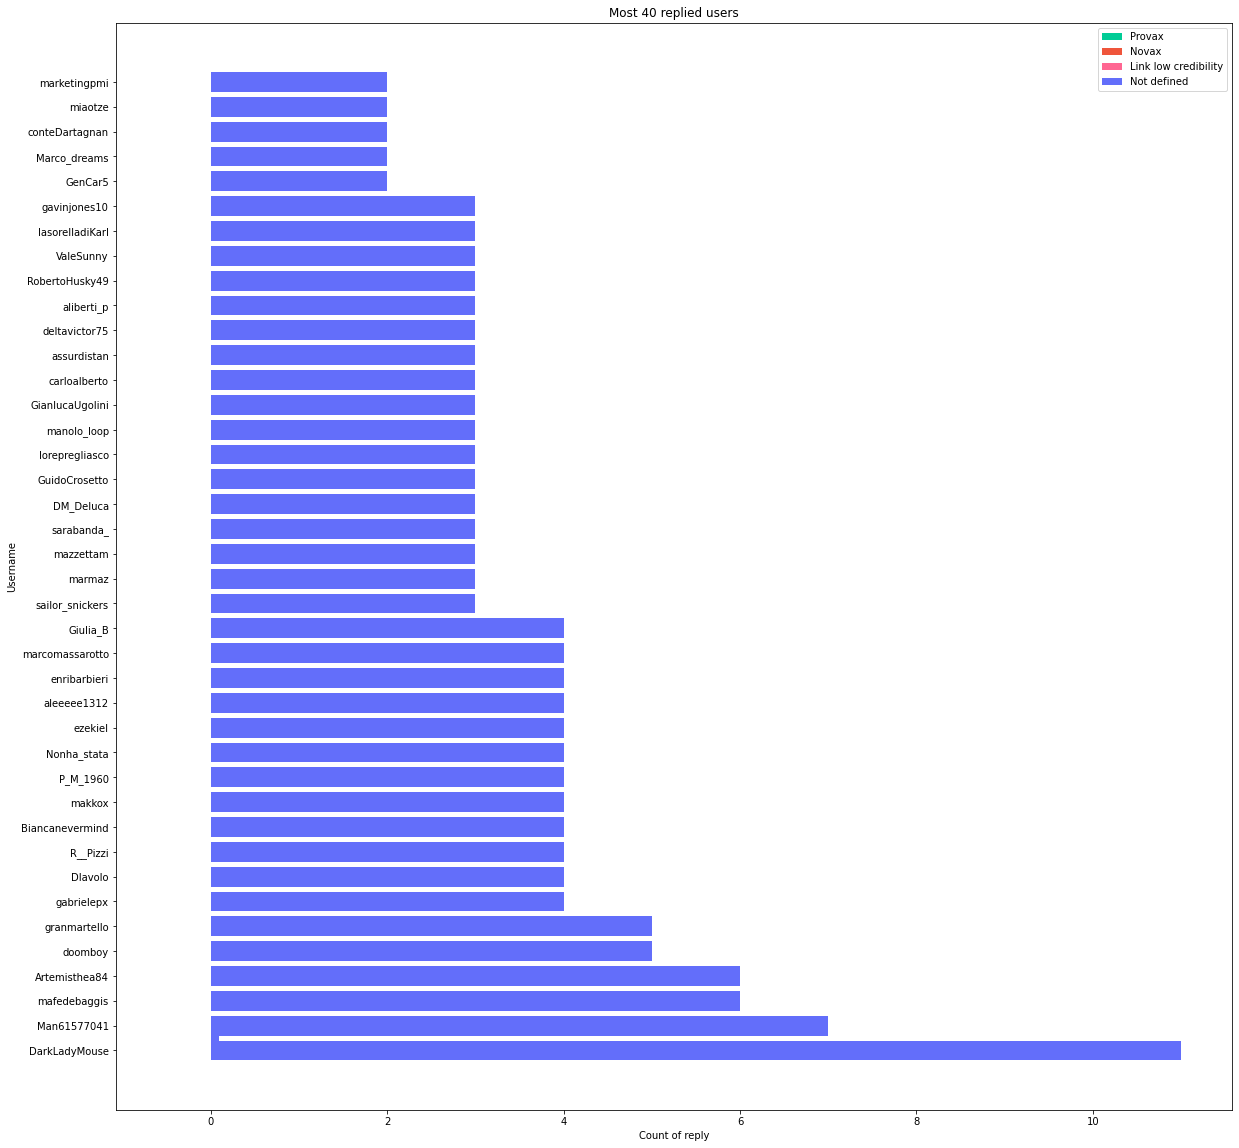

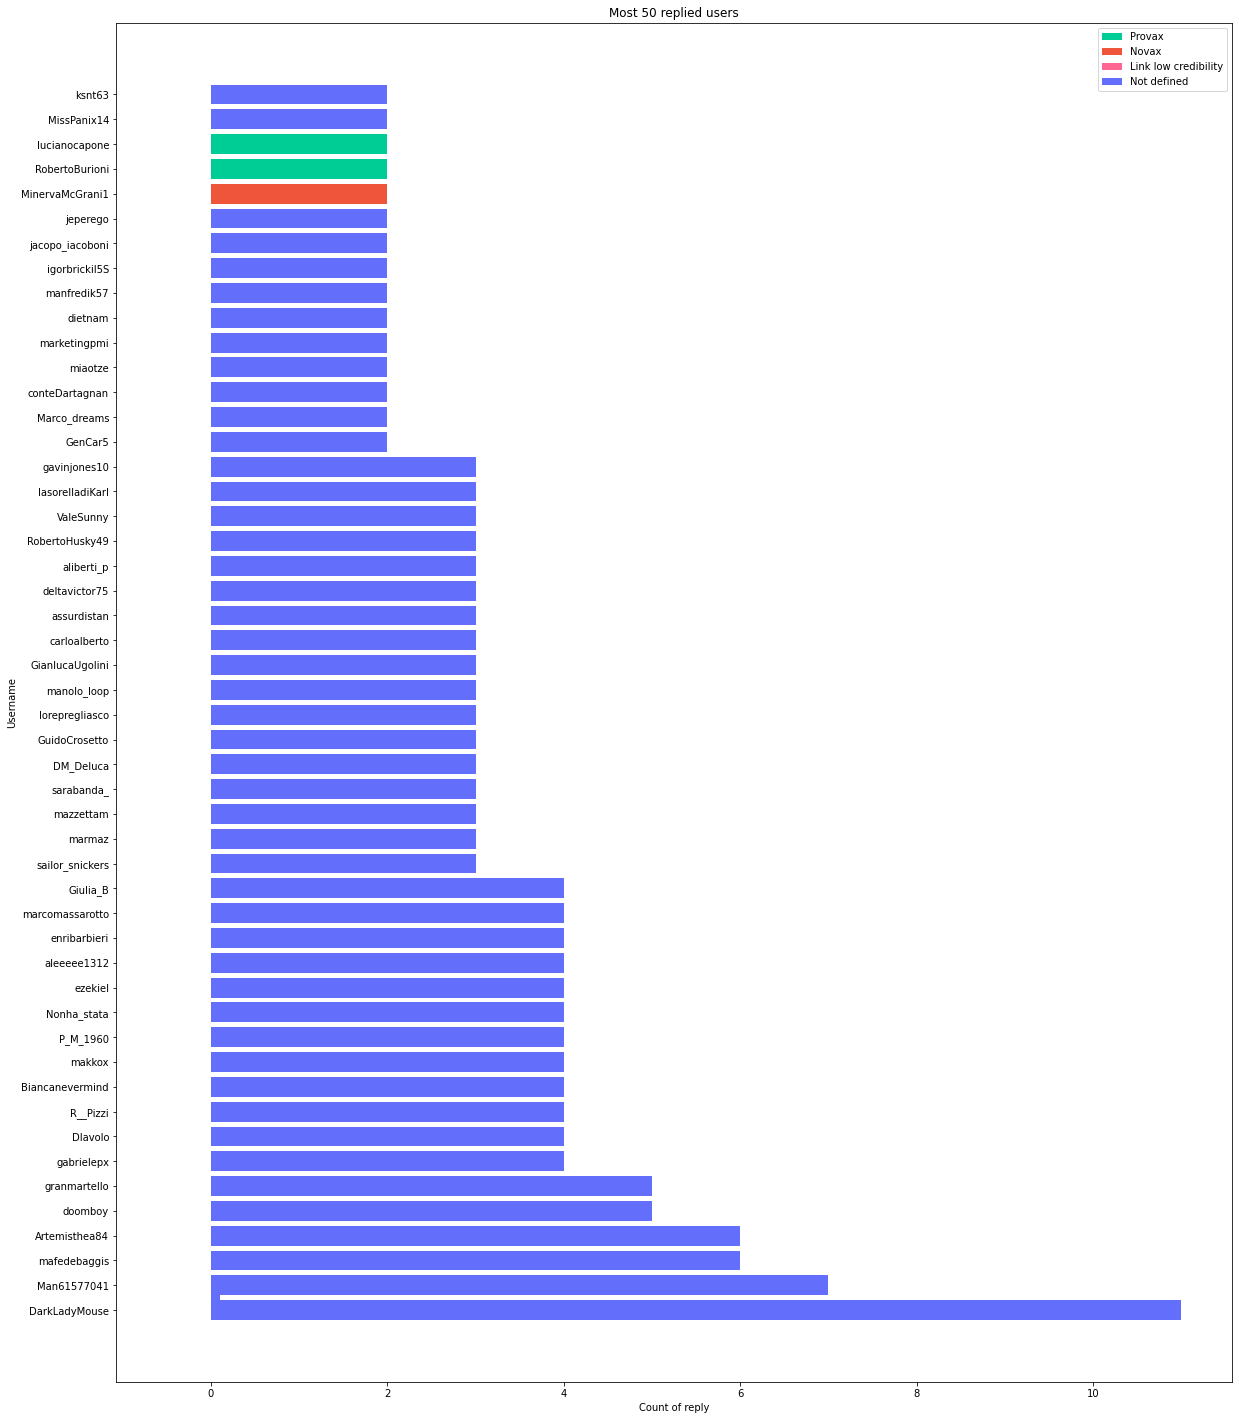

In [18]:
df_replied = ut.get_df_raggruped(reply,'reply','in_reply_to_screen_name')
df_replied = ut.add_user_type(df_replied,listNovax,listProvax,listLinkLow)[['reply','user_type']]

for i in (10,20,40,50):
        ut.print_histogram_users(df_replied,i,'reply','Most %d replied users'%i,'Count of reply')

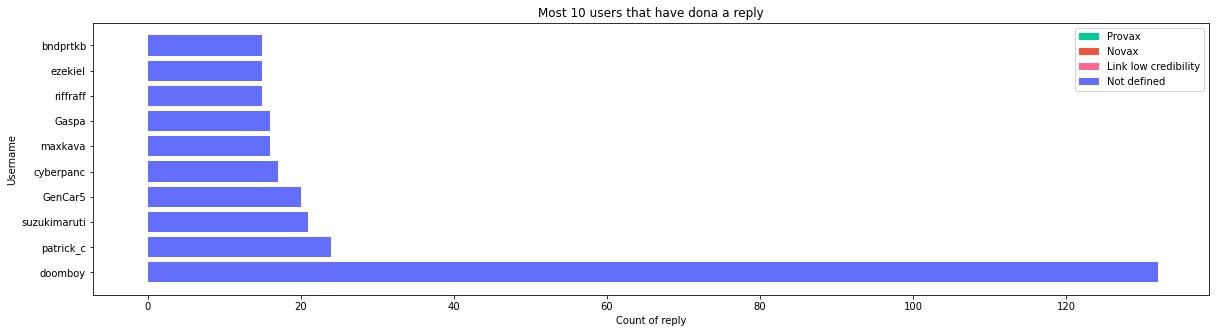

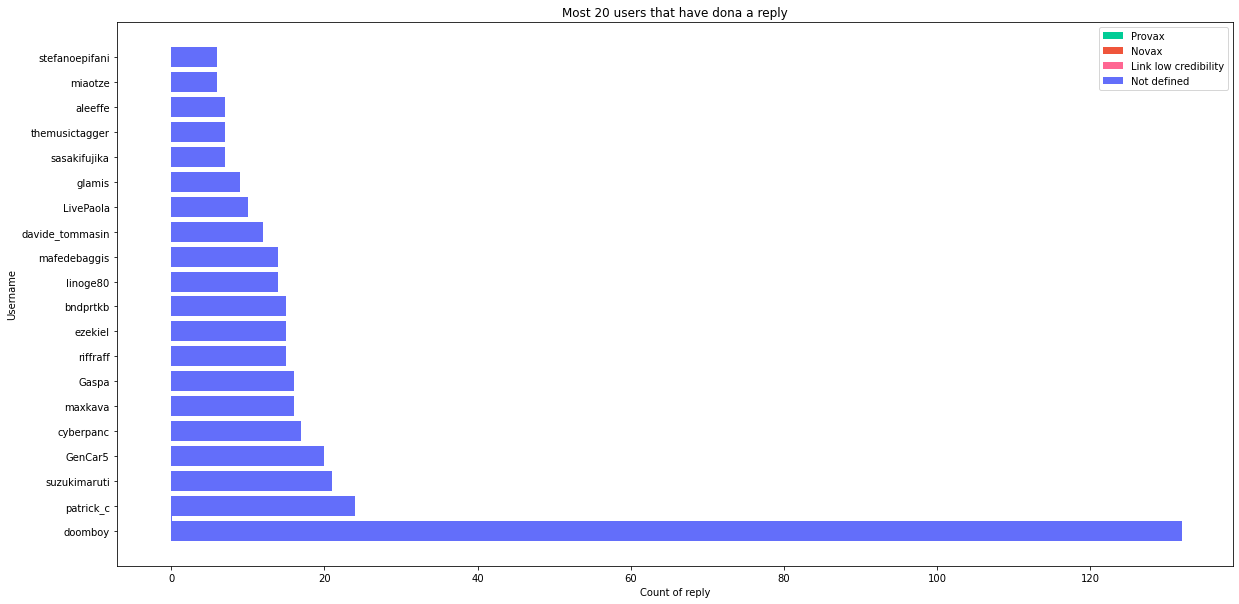

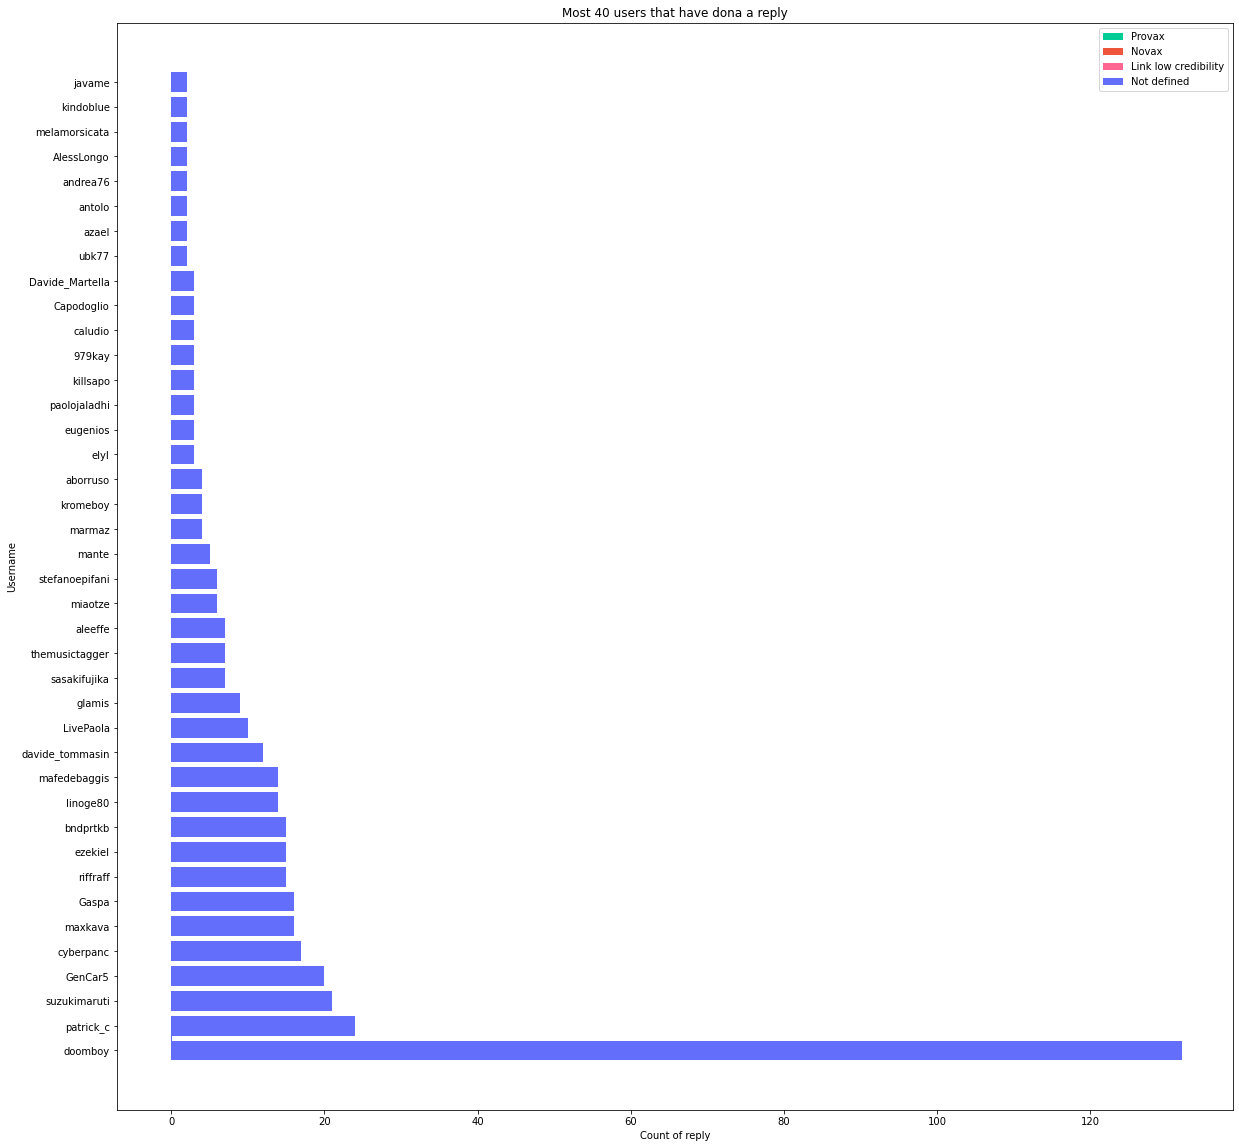

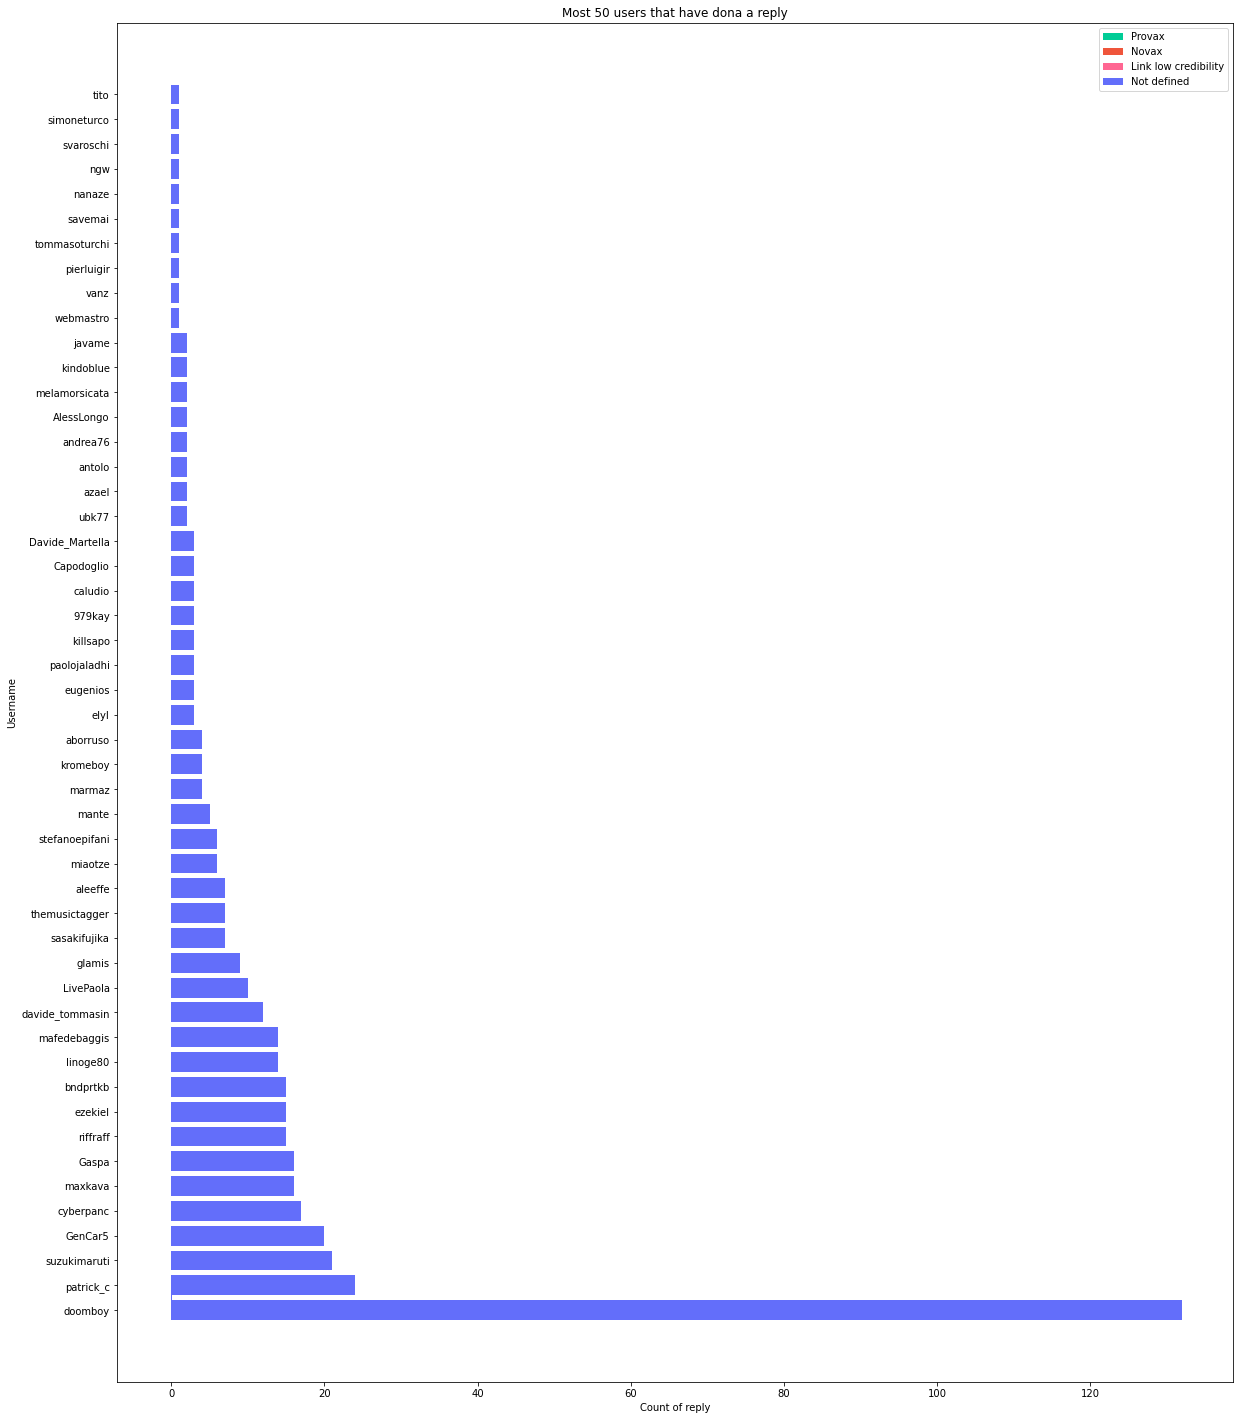

In [19]:
df_reply_done = ut.get_df_raggruped(reply,'reply','user_screen_name')
df_reply_done = ut.add_user_type(df_reply_done,listNovax,listProvax,listLinkLow)[['reply','user_type']]

for i in (10,20,40,50):
        ut.print_histogram_users(df_reply_done,i,'reply','Most %d users that have dona a reply'%i,'Count of reply')

### Quote study

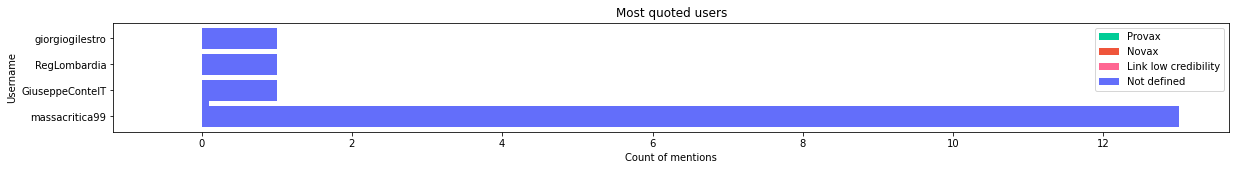

In [20]:
df_quotes = pd.read_csv('../Tweet_split_type/quotes.csv')
df_quotes = df_quotes[[ele in df.user_id for ele in df_quotes.user_id]]

df_quotes = ut.get_df_raggruped(df_quotes,'quotes_count','in_reply_to_screen_name')
df_quotes = ut.add_user_type(df_quotes,listNovax,listProvax,listLinkLow)[['quotes_count','user_type']]

ut.print_histogram_users(df_quotes,len(df_quotes),'quotes_count','Most quoted users','Count of mentions')

### Tweets distrubution

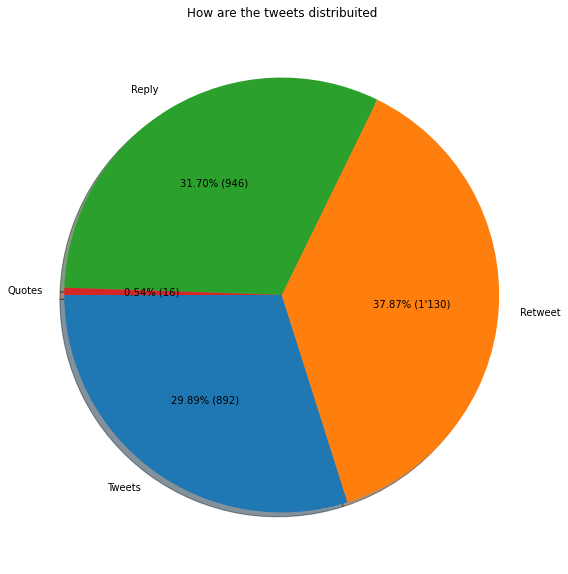

In [21]:
retweet = sum(df_retweet['all_rt'])
reply = sum(df_replied['reply']) + sum(df_reply_done['reply'])
quotes = sum(df_quotes['quotes_count'])

tweet = sum(df_tweets['tweet_count'])

values = [tweet,retweet,reply,quotes]
names = ['Tweets', 'Retweet','Reply','Quotes']

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(values, labels=names, autopct=lambda p:f'{p:.2f}% ({p*sum(values)/100 :,.0f})'.replace(',', '\''),
        shadow=True, startangle=180)

plt.title("How are the tweets distribuited")
plt.show()

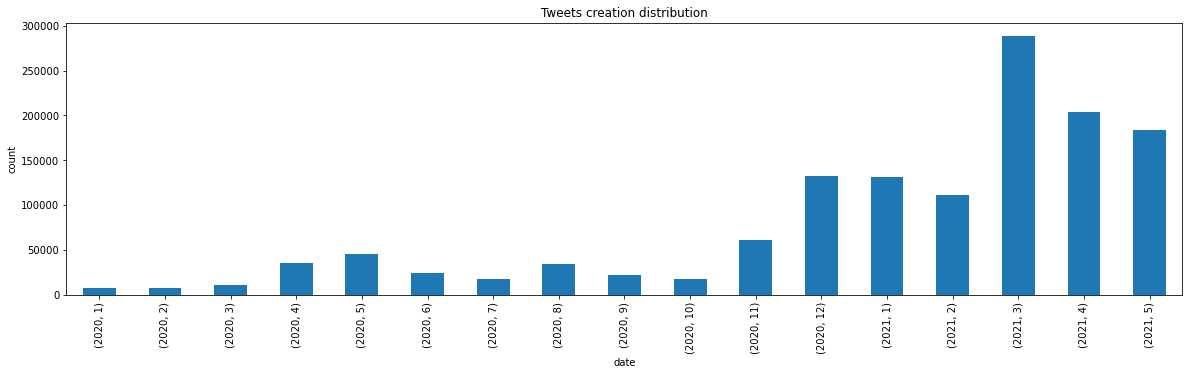

In [22]:
plt.figure(figsize=(20,5))
df.groupby([df["created_at"].dt.year,df["created_at"].dt.month])['created_at'].count().plot(kind="bar")
plt.xlabel('date')
plt.ylabel('count')
plt.title('Tweets creation distribution')
plt.show()

# User credibility (based on url shared)

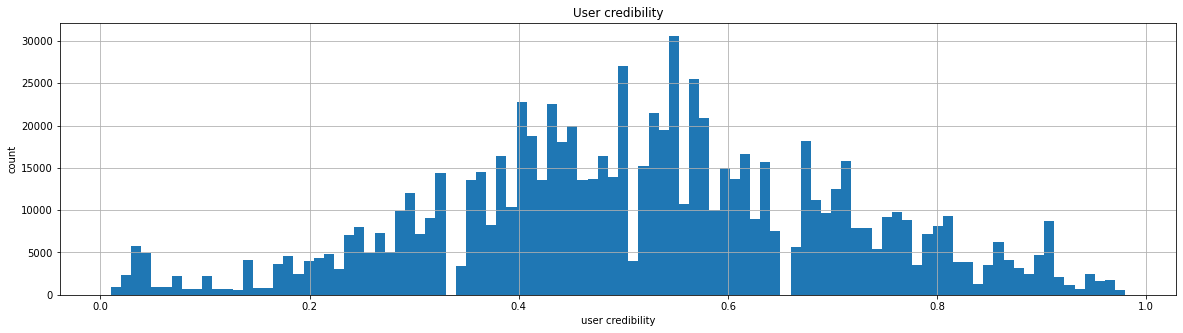

In [23]:
df1 = df[df['user_url_cred'].notna()]
user_credibility = df1.loc[df1['user_url_cred']<1,'user_url_cred']
user_credibility = user_credibility[user_credibility > 0]

plt.figure(figsize=(20,5))
user_credibility.hist(bins=100)
plt.xlabel('user credibility')
plt.ylabel('count')
plt.title('User credibility')
plt.show()